<a href="https://colab.research.google.com/github/dantidn/SAHASTA-Machine-Learning/blob/main/Food_Model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

## Create a dataframe of the form filepaths labels

In [ ]:
sdir=r'C:\Users\ASUS\Downloads\SAHASTA-Machine-Learning\data'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   apel
1  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   apel
2  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   apel
3  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   apel
4  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   apel
labels
brokoli    111
kacang     111
bubur      108
roti        98
ayam        96
jagung      94
pisang      94
susu        92
keju        89
apel        84
Name: count, dtype: int64


In [ ]:
print(train_df.head())

                                             filepaths  labels
90   C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...    ayam
75   C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...    apel
469  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...  jagung
947  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...    susu
314  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   bubur


In [ ]:
print(valid_df.head())

                                             filepaths   labels
156  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...     ayam
900  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...     susu
236  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...  brokoli
487  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   jagung
741  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   pisang


In [ ]:
print(test_df.head())

                                             filepaths   labels
625  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...     keju
246  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...  brokoli
746  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...   pisang
161  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...     ayam
920  C:\Users\ASUS\Downloads\SAHASTA-Machine-Learni...     susu


In [ ]:
def check_file_exists(filepaths):
    return os.path.exists(filepaths)

train_df['exists'] = train_df['filepaths'].apply(check_file_exists)
valid_df['exists'] = valid_df['filepaths'].apply(check_file_exists)
test_df['exists'] = test_df['filepaths'].apply(check_file_exists)

# Filter out rows with missing files
train_df = train_df[train_df['exists']]
valid_df = valid_df[valid_df['exists']]
test_df = test_df[test_df['exists']]

In [ ]:
print(check_file_exists)

<function check_file_exists at 0x00000177B9A66670>


In [ ]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 724 validated image filenames belonging to 10 classes.


C:\Users\ASUS\anaconda3\envs\CNN\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 57 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


## Split df into train_df, test_df and valid_df

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  781   test_df length:  98   valid_df length:  98


## Create train, test, valid generators

In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  49   test steps:  2
Found 724 validated image filenames belonging to 10 classes.
Found 86 validated image filenames belonging to 10 classes.
Found 91 validated image filenames belonging to 10 classes.
['apel', 'ayam', 'brokoli', 'bubur', 'jagung', 'kacang', 'keju', 'pisang', 'roti', 'susu']


C:\Users\ASUS\anaconda3\envs\CNN\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 57 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\CNN\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 12 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\CNN\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 7 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


## Create function to show some image examples

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

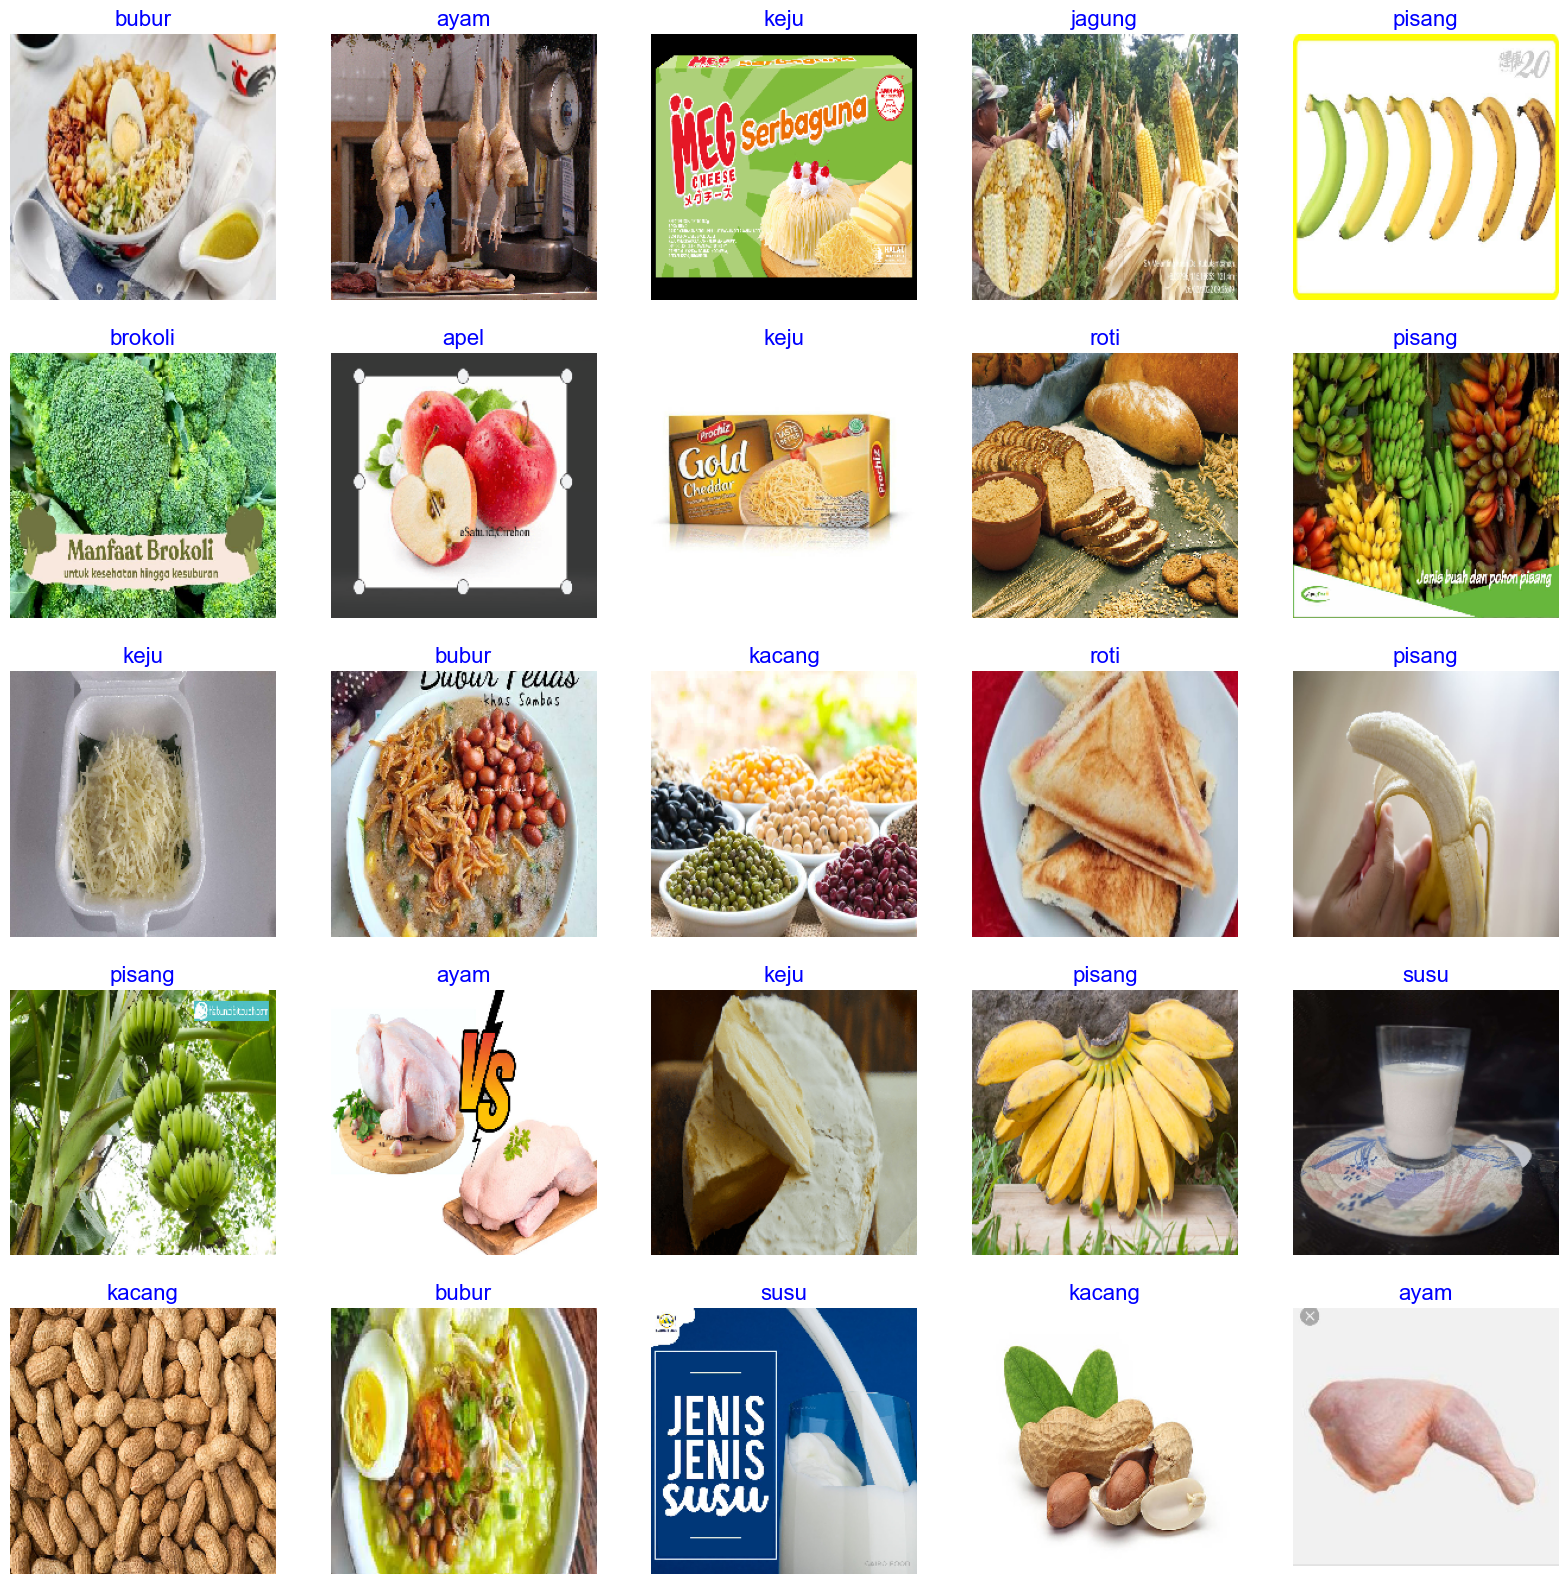

In [ ]:
show_image_samples(train_gen)

## Create the model

In [ ]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
base_model.trainable = False

In [ ]:
model_name='SAHASTA'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x00000177D461D520>


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2890      
                                                      

In [ ]:
epochs =100

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100
 6/12 [==============>...............] - ETA: 14s - loss: 2.6353 - accuracy: 0.2853

C:\Users\ASUS\anaconda3\envs\CNN\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 [==============================] - 43s 3s/step - loss: 2.0657 - accuracy: 0.3771 - val_loss: 1.1229 - val_accuracy: 0.5930
Epoch 2/100
12/12 [==============================] - 36s 3s/step - loss: 1.0330 - accuracy: 0.6312 - val_loss: 0.6642 - val_accuracy: 0.7791
Epoch 3/100
12/12 [==============================] - 36s 3s/step - loss: 0.7654 - accuracy: 0.7334 - val_loss: 0.5645 - val_accuracy: 0.8605
Epoch 4/100
12/12 [==============================] - 35s 3s/step - loss: 0.4699 - accuracy: 0.8356 - val_loss: 0.4194 - val_accuracy: 0.8837
Epoch 5/100
12/12 [==============================] - 37s 3s/step - loss: 0.3643 - accuracy: 0.8785 - val_loss: 0.3979 - val_accuracy: 0.9070
Epoch 6/100
12/12 [==============================] - 40s 3s/step - loss: 0.2751 - accuracy: 0.9144 - val_loss: 0.2911 - val_accuracy: 0.9186
Epoch 7/100
12/12 [==============================] - 38s 3s/step - loss: 0.1870 - accuracy: 0.9392 - val_loss: 0.3167 - val_accuracy: 0.8953
Epoch 8/100
12/12 [======

## Define function to print text in RGB foreground and background colors

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

## Define function to plot the training data

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

## Define function to generate the confusion matrix and classification report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

## Evaluate model on the test set then save the model

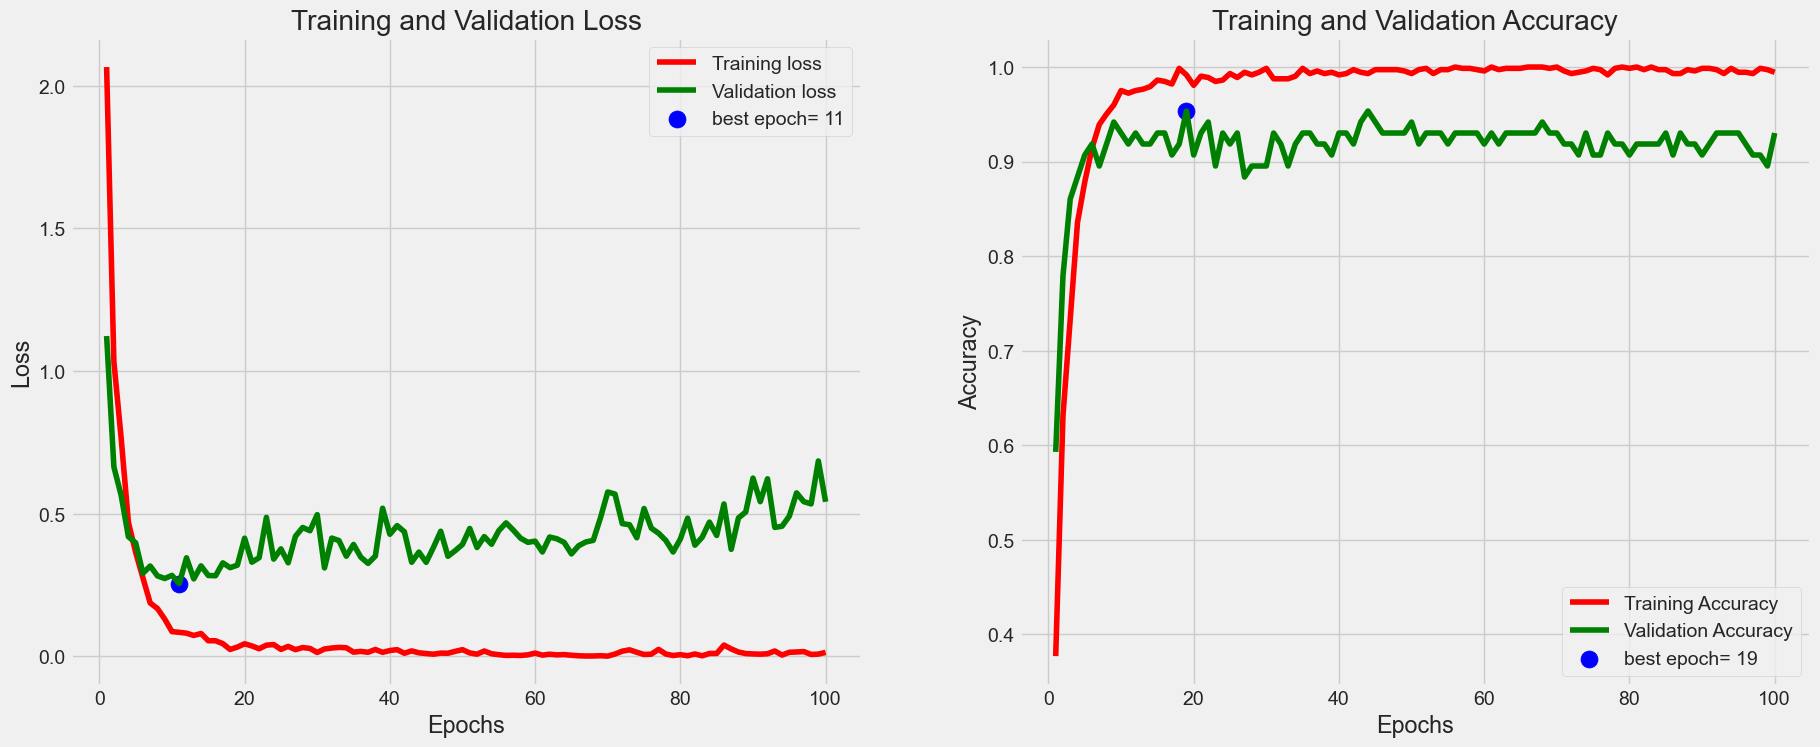

2/2 [==============================] - 4s 2s/step - loss: 0.9290 - accuracy: 0.9231
accuracy on the test set is 92.31 %



In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='Food Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

## Make predictions on test set and generate confusion matrix and classification report

2/2 [==============================] - 5s 2s/step


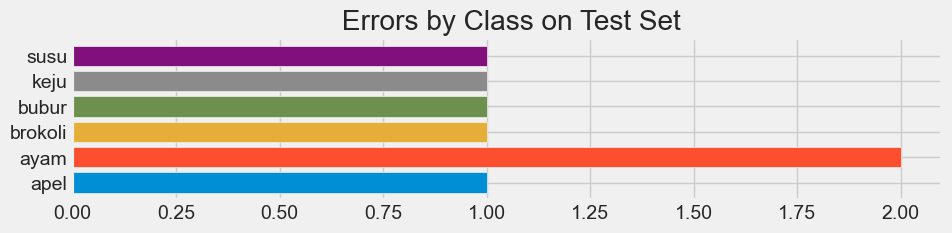

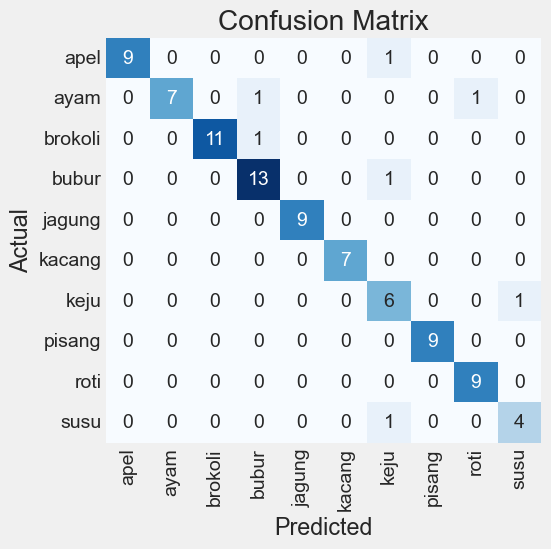

Classification Report:
----------------------
               precision    recall  f1-score   support

        apel       1.00      0.90      0.95        10
        ayam       1.00      0.78      0.88         9
     brokoli       1.00      0.92      0.96        12
       bubur       0.87      0.93      0.90        14
      jagung       1.00      1.00      1.00         9
      kacang       1.00      1.00      1.00         7
        keju       0.67      0.86      0.75         7
      pisang       1.00      1.00      1.00         9
        roti       0.90      1.00      0.95         9
        susu       0.80      0.80      0.80         5

    accuracy                           0.92        91
   macro avg       0.92      0.92      0.92        91
weighted avg       0.93      0.92      0.92        91



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )